In [1]:
%load_ext autoreload
%autoreload 2
from model import *
from model import EF, train_model
import jax
# from jax import config
# config.update('jax_enable_x64', True)
import optax
from dcmnet.analysis import create_model_and_params
from dcmnet.data import prepare_batches, prepare_datasets


<Figure size 100x100 with 0 Axes>

In [2]:
# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]
[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


2024-11-19 19:34:38.706787: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:1: CUDA error: : CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable


In [3]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(420), 2)

2024-11-19 19:34:38.917536: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
files = ["/pchem-data/meuwly/boittier/home/jaxeq/notebooks/ala-esp-dip-0.npz"]

In [5]:
train_data, valid_data = prepare_datasets(data_key, 10000, 1242,
                                          files, 
                                          clip_esp=False, natoms=60, clean=False)

shape (11242, 60, 3) not failed [    0     1     2 ... 11239 11240 11241]
dataR (11242, 60, 3)
R (11242, 60, 3)
(11242,)
['id', 'R', 'Z', 'F', 'E', 'N', 'esp', 'vdw_surface', 'n_grid', 'Dxyz', 'com']
11242
0 id 11242 (11242,)
1 R 11242 (11242, 60, 3)
2 Z 11242 (11242, 60)
3 F 11242 (11242, 60, 3)
4 E 11242 (11242, 1)
5 N 11242 (11242, 1)
6 esp 11242 (11242, 10000)
7 vdw_surface 11242 (11242, 10000, 3)
8 n_grid 11242 (11242,)
9 Dxyz 11242 (11242, 3)
10 com 11242 (11242, 3)


In [6]:
model = EF(
    # attributes
    features = 32,
    max_degree = 4,
    num_iterations = 2,
    num_basis_functions = 16,
    cutoff = 6.0,
    max_atomic_number = 32,
)
model

EF(
    # attributes
    features = 32
    max_degree = 4
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 6.0
    max_atomic_number = 32
)

In [11]:
batch_size = 2

In [12]:
train_batches = prepare_batches(data_key, train_data, batch_size, 
                                data_keys=["Z", "R", "E", "F"], 
                                num_atoms=60)
for _ in train_batches[0].keys():
    print(_,train_batches[0][_].shape,train_batches[0][_].dtype)

R (120, 3) float64
Z (120,) int64
F (120, 3) float64
E (2, 1) float64
dst_idx (7080,) int32
src_idx (7080,) int32
batch_segments (120,) int32


In [13]:
# train_batches[0]["F"],train_batches[1]["F"]

In [ ]:
params = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    500,
    0.001, 
    100,
    batch_size,
    num_atoms=60,
    # restart = params,
)

init_key.dtype uint32
epoch:   1                    train:   valid:
    loss [a.u.]              32322.592  6143.458
    energy mae [kcal/mol]    148.697  109.868
    forces mae [kcal/mol/Å]    4.604    4.313
epoch:   2                    train:   valid:
    loss [a.u.]              4927.191  3141.777
    energy mae [kcal/mol]    105.858  103.270
    forces mae [kcal/mol/Å]    3.891    3.171
epoch:   3                    train:   valid:
    loss [a.u.]              2703.412  2230.766
    energy mae [kcal/mol]    102.788  107.375
    forces mae [kcal/mol/Å]    2.906    2.605
epoch:   4                    train:   valid:
    loss [a.u.]              1967.745  1696.461
    energy mae [kcal/mol]    101.818  101.721
    forces mae [kcal/mol/Å]    2.506    2.323
epoch:   5                    train:   valid:
    loss [a.u.]              1611.011  1454.603
    energy mae [kcal/mol]    100.471  101.187
    forces mae [kcal/mol/Å]    2.272    2.172
epoch:   6                    train:   valid:
 

In [15]:
import pickle
with open(f"checkpoints/test.pkl", "wb") as file:
    pickle.dump(params, file)

In [35]:
# @jax.jit
# def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
#   return model.apply(params,
#     atomic_numbers=atomic_numbers,
#     positions=positions,
#     dst_idx=dst_idx,
#     src_idx=src_idx,
#   )
NATOMS = 60
import numpy as np

In [36]:
valid_batches = prepare_batches(data_key, valid_data, batch_size*2,
                              num_atoms=NATOMS, 
                              data_keys=['R', 'Z', 'F', 'E',
                               'dst_idx', 'src_idx', 'batch_segments'])
# @jax.jit
def eval():
    Es, predEs, Fs, predFs = [], [], [], []
    for i, batch in enumerate(valid_batches[:]):
      energy, forces = model.apply(
        params,
        atomic_numbers=batch['Z'],
        positions=batch['R'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size*2
      )
      Es.append(batch["E"])
      predEs.append(energy)
      Fs.append(batch["F"])
      predFs.append(forces)
    
    Es = np.array(Es).flatten()
    predEs = np.array(predEs).flatten()
    Fs = np.array(Fs).flatten()
    predFs = np.array(predFs).flatten()
    return Es, predEs, Fs, predFs 

Es, predEs, Fs, predFs = eval()

disp (70800, 3)
basis (70800, 1, 25, 16)
x (1200, 1, 1, 32)
x (1200, 1, 1, 32)
y (1200, 1, 25, 32)
x (1200, 1, 1, 32)
y (1200, 1, 1, 32)
disp (70800, 3)
basis (70800, 1, 25, 16)
x (1200, 1, 1, 32)
x (1200, 1, 1, 32)
y (1200, 1, 25, 32)
x (1200, 1, 1, 32)
y (1200, 1, 1, 32)
disp (70800, 3)
basis (70800, 1, 25, 16)
x (1200, 1, 1, 32)
x (1200, 1, 1, 32)
y (1200, 1, 25, 32)
x (1200, 1, 1, 32)
y (1200, 1, 1, 32)
disp (70800, 3)
basis (70800, 1, 25, 16)
x (1200, 1, 1, 32)
x (1200, 1, 1, 32)
y (1200, 1, 25, 32)
x (1200, 1, 1, 32)
y (1200, 1, 1, 32)
disp (70800, 3)
basis (70800, 1, 25, 16)
x (1200, 1, 1, 32)
x (1200, 1, 1, 32)
y (1200, 1, 25, 32)
x (1200, 1, 1, 32)
y (1200, 1, 1, 32)
disp (70800, 3)
basis (70800, 1, 25, 16)
x (1200, 1, 1, 32)
x (1200, 1, 1, 32)
y (1200, 1, 25, 32)
x (1200, 1, 1, 32)
y (1200, 1, 1, 32)
disp (70800, 3)
basis (70800, 1, 25, 16)
x (1200, 1, 1, 32)
x (1200, 1, 1, 32)
y (1200, 1, 25, 32)
x (1200, 1, 1, 32)
y (1200, 1, 1, 32)
disp (70800, 3)
basis (70800, 1, 25, 16)


1.113177626264642 0.7549288251852488


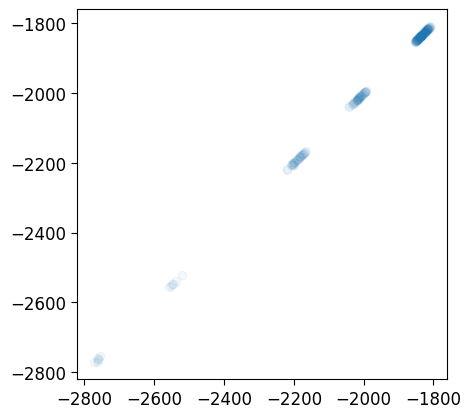

0.8027993830612148 0.35961436875442654


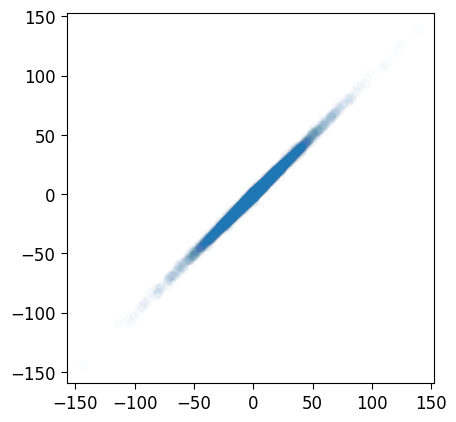

In [37]:
import matplotlib.pyplot as plt
ERROR = Es - predEs
RMSE = np.mean(ERROR**2)**0.5
MAE = np.mean(abs(ERROR))
print(RMSE, MAE)

plt.scatter(Es, predEs, alpha=0.05)
ax = plt.gca()
ax.set_aspect("equal")
plt.show()
plt.scatter(Fs, predFs, alpha=0.01)
ax = plt.gca()
ax.set_aspect("equal")

ERROR = Fs - predFs
RMSE = np.mean(ERROR**2)**0.5
MAE = np.mean(abs(ERROR))
print(RMSE, MAE)

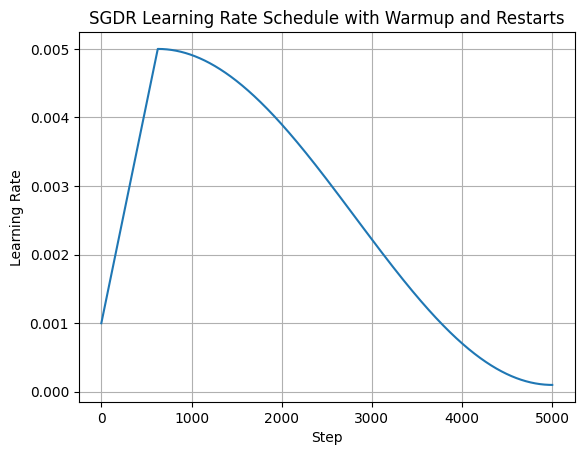

In [3]:
import optax
import matplotlib.pyplot as plt

num_epochs = 5000
learning_rate = 0.001
# Define the parameters for each cosine decay cycle with warmup
cosine_kwargs =  [
        {"end_value": learning_rate/10, "peak_value": learning_rate*5, "init_value": learning_rate, 
         "warmup_steps": num_epochs//8, "decay_steps": num_epochs},  # 
    ]
# Create the SGDR schedule with warm restarts
schedule_fn = optax.schedules.sgdr_schedule(cosine_kwargs=cosine_kwargs)

# Generate learning rate values for visualization
steps = range(num_epochs)  # Total steps spanning all cycles
learning_rates = [schedule_fn(step) for step in steps]

# Plot the SGDR learning rate schedule
plt.plot(steps, learning_rates)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
# plt.yscale("log")
plt.title('SGDR Learning Rate Schedule with Warmup and Restarts')
plt.grid()
plt.show()


In [101]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [102]:
@jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
  return model.apply(params,
    atomic_numbers=atomic_numbers,
    positions=positions,
    dst_idx=dst_idx,
    src_idx=src_idx,
  )


class MessagePassingCalculator(ase_calc.Calculator):
  implemented_properties = ["energy", "forces"]

  def calculate(self, atoms, properties, system_changes = ase.calculators.calculator.all_changes):
    ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
    energy, forces = evaluate_energies_and_forces(
      atomic_numbers=atoms.get_atomic_numbers(),
      positions=atoms.get_positions(),
      dst_idx=dst_idx,
      src_idx=src_idx
    )

    self.results['energy'] = energy.squeeze() * (ase.units.kcal/ase.units.mol)
    self.results['forces'] = forces * (ase.units.kcal/ase.units.mol) #/ase.units.Angstrom

In [103]:
# Initialize atoms object and attach calculator.
i = 10

Natoms = int(train_data['N'][i])
R = train_data['R'][i][:Natoms] - np.mean(train_data['R'][i][:Natoms], axis=0)
# print(R)
atoms = ase.Atoms(train_data['Z'][i][:Natoms], R )
atoms.set_calculator(MessagePassingCalculator())

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [105]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(atoms).run(fmax=0.001)

      Step     Time          Energy          fmax
BFGS:    0 15:30:06      -62.136147        0.429608
BFGS:    1 15:30:06      -62.138809        0.316034
BFGS:    2 15:30:06      -62.142170        0.164521
BFGS:    3 15:30:06      -62.145138        0.179609
BFGS:    4 15:30:06      -62.145741        0.207332
BFGS:    5 15:30:06      -62.149521        0.202188
BFGS:    6 15:30:06      -62.152020        0.155487
BFGS:    7 15:30:06      -62.155552        0.109261
BFGS:    8 15:30:06      -62.157776        0.124042
BFGS:    9 15:30:06      -62.162136        0.138584
BFGS:   10 15:30:06      -62.164776        0.148651
BFGS:   11 15:30:06      -62.170006        0.150701
BFGS:   12 15:30:06      -62.172558        0.206260
BFGS:   13 15:30:06      -62.173840        0.118992
BFGS:   14 15:30:06      -62.177635        0.101376
BFGS:   15 15:30:06      -62.180698        0.135278
BFGS:   16 15:30:06      -62.182617        0.118206
BFGS:   17 15:30:06      -62.183258        0.096070
BFGS:   18 15:

In [106]:
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [107]:
# Parameters.
temperature = 300
timestep_fs = 0.1
num_steps = 100_000

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # Occasionally print progress.q
  if i % 1000 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -62.255 ekin  0.844 etot -61.410
step  1000 epot -61.868 ekin  0.458 etot -61.410
step  2000 epot -61.780 ekin  0.368 etot -61.411
step  3000 epot -61.827 ekin  0.416 etot -61.411
step  4000 epot -61.881 ekin  0.469 etot -61.412
step  5000 epot -61.892 ekin  0.479 etot -61.413
step  6000 epot -61.826 ekin  0.415 etot -61.411
step  7000 epot -61.875 ekin  0.463 etot -61.412
step  8000 epot -61.817 ekin  0.404 etot -61.413
step  9000 epot -61.950 ekin  0.538 etot -61.412
step 10000 epot -62.041 ekin  0.628 etot -61.413
step 11000 epot -61.724 ekin  0.310 etot -61.414
step 12000 epot -61.915 ekin  0.501 etot -61.413
step 13000 epot -61.990 ekin  0.578 etot -61.412
step 14000 epot -61.904 ekin  0.490 etot -61.413
step 15000 epot -61.851 ekin  0.440 etot -61.411
step 16000 epot -61.927 ekin  0.514 etot -61.413
step 17000 epot -61.882 ekin  0.468 etot -61.414
step 18000 epot -61.999 ekin  0.585 etot -61.414
step 19000 epot -61.964 ekin  0.552 etot -61.411
step 20000 epot -61.

In [108]:
# view.getModel().setCoordinates(frames[::10], 'array')
# view.animate({'loop': "forward", 'interval': 0.1})
# view.show()

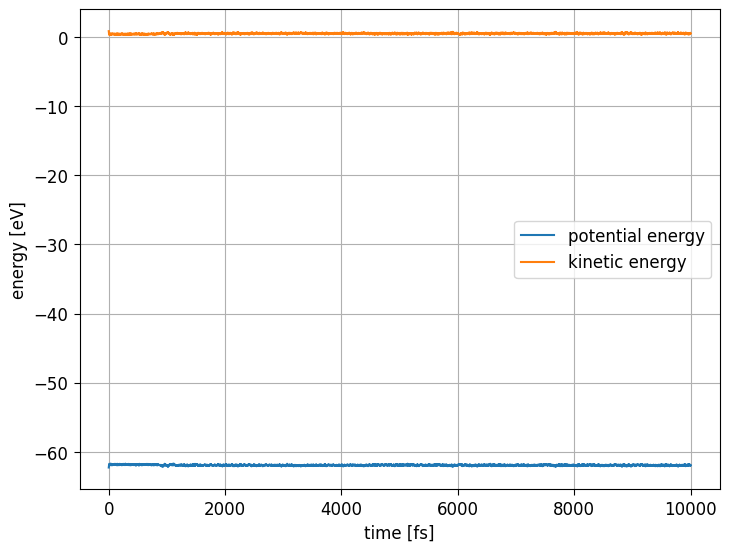

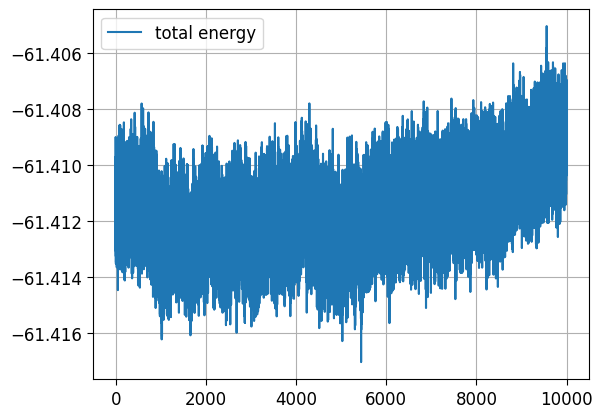

In [109]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.legend()
plt.grid()
plt.show()
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()

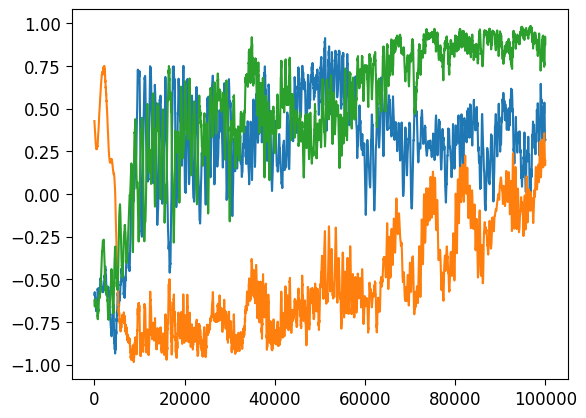

In [129]:
r = frames[:,-3] - frames[:,-2]
for i in range(3):
    plt.plot(r[:,i])

In [130]:
from statsmodels.tsa.stattools import acovf
10**6/1000

1000.0

In [131]:
# total_dipole_vectors = total_dipole_vectors[NSKIP::]
from ase import units

# Time for speed of light in vacuum to travel 1cm (0.01) in 1fs (1e15)
jiffy = 0.01 / units._c * 1e12

# dipo_list = np.array(total_dipole_vectors)
dtime = timestep_fs * 0.001
# Frequency range in cm^-1
Nframes = len(r)
print("Nframes: ", Nframes)
Nfreq = int(Nframes / 2) + 1

freq = np.arange(Nfreq) / float(Nframes) / dtime * jiffy

# Dipole-Dipole autocorrelation function
acvx = acovf(r[:, 0], fft=True)
acvy = acovf(r[:, 1], fft=True)
acvz = acovf(r[:, 2], fft=True)
acv = acvx + acvy + acvz

acv = acv * np.blackman(len(r))
spectra = np.abs(np.fft.rfftn(acv)) 

Nframes:  100000


(0.0, 4000.0)

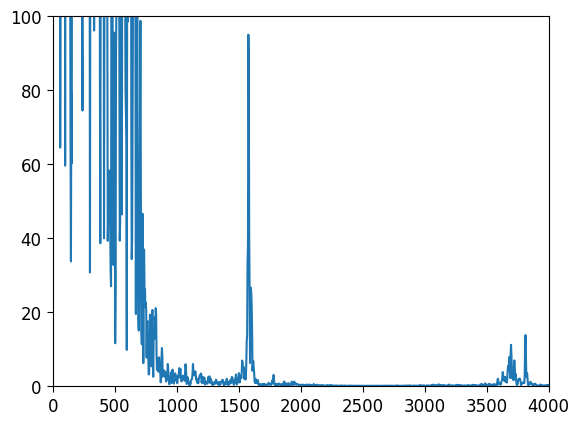

In [132]:
plt.plot(freq, 100*spectra)
# plt.ylim(0,0.0000005)
# plt.xlim(100, 150)
# plt.yscale("log")
plt.ylim(0,100)
plt.xlim(0, 4000)